<a href="https://colab.research.google.com/github/1eetnals/Body-Morphometry-kidney-and-tumor/blob/main/unetr_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureType,
    ToTensord,
    MapTransform,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
from monai.apps import download_and_extract

import torch

print_config()

MONAI version: 0.7.dev2134
Numpy version: 1.20.1
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b5a2e745f93752d1dec38c6c138993c6dddd85da

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.0
tqdm version: 4.59.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.2.4
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
root_dir='./pth_file/'

In [ ]:
test_path = '/nfs/hufsbme/moai2021/data/test/NIFTI/'
Input_folder = os.listdir(test_path)
test_files = []

for i in range(0,len(Input_folder)):
    if Input_folder[i].startswith('nifti'):
        data_file=os.listdir(test_path+Input_folder[i])
        for j in range(0,len(data_file)):
            if data_file[j].endswith('.nii.gz'):
                test_files.append(test_path+Input_folder[i]+'/'+data_file[j])

test_files.sort()
test_files

['/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test001/ct_test001.nii.gz',
 '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test002/ct_test002.nii.gz',
 '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test003/ct_test003.nii.gz',
 '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test004/ct_test004.nii.gz',
 '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test005/ct_test005.nii.gz',
 '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test006/ct_test006.nii.gz',
 '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test007/ct_test007.nii.gz',
 '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test008/ct_test008.nii.gz',
 '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test009/ct_test009.nii.gz',
 '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test010/ct_test010.nii.gz',
 '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test011/ct_test011.nii.gz',
 '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test012/ct_test012.nii.gz',
 '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test013/ct_test013.nii.gz',
 '/nfs/hufsbme/moai2021/data/test/NIFT

In [ ]:
test_ind=np.arange(0,83)
data_dicts=[
    {
       "image": test_files[idx]
    }
    for idx in test_ind
]

test_f=data_dicts
print(len(test_f))
test_f

83


[{'image': '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test001/ct_test001.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test002/ct_test002.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test003/ct_test003.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test004/ct_test004.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test005/ct_test005.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test006/ct_test006.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test007/ct_test007.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test008/ct_test008.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test009/ct_test009.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test010/ct_test010.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test011/ct_test011.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/test/NIFTI/nifti_test012/c

In [ ]:
class ConvertToMultiChannel(MapTransform):
    """
    Convert labels to multi channels:
    """
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(d[key].astype(np.int8) >0)
#            result.append(d[key].astype(np.int8) == 1)
#            result.append(d[key].astype(np.int8) == 2)
#            result.append(d[key].astype(np.int8) == 4)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [ ]:
'''
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image"]),
        ConvertToMultiChannel(keys=["label"]), 
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.7, 1.7, 1.7),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image"], axcodes="RAS"),
        Orientationd(keys=["label"], axcodes="RPS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-285, a_max=350, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)
'''

In [ ]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        AddChanneld(keys=["image"]),
        #ConvertToMultiChannel(keys=["label"]), 
        Spacingd(
            keys=["image"],
            pixdim=(1.7, 1.7, 1.7),
            mode=("bilinear"),
        ),
        Orientationd(keys=["image"], axcodes="RAS"),
        #Orientationd(keys=["label"], axcodes="RPS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-285, a_max=350, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        ToTensord(keys=["image"]),
    ]
)

In [ ]:
test_ds = CacheDataset(
    data=test_f, transform=test_transforms, cache_rate=1.0, num_workers=0
)
test_loader = DataLoader(
    test_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True
)

Loading dataset: 100%|██████████| 83/83 [03:39<00:00,  2.64s/it]


In [ ]:
from monai.transforms import LoadImage

for test_image in test_loader:
  print(test_image['image'].shape)

torch.Size([1, 1, 302, 247, 38])
torch.Size([1, 1, 302, 231, 38])
torch.Size([1, 1, 299, 225, 38])
torch.Size([1, 1, 299, 290, 38])
torch.Size([1, 1, 302, 252, 38])
torch.Size([1, 1, 301, 275, 38])
torch.Size([1, 1, 302, 230, 38])
torch.Size([1, 1, 302, 285, 38])
torch.Size([1, 1, 261, 219, 38])
torch.Size([1, 1, 291, 266, 38])
torch.Size([1, 1, 271, 236, 38])
torch.Size([1, 1, 292, 253, 38])
torch.Size([1, 1, 275, 219, 38])
torch.Size([1, 1, 286, 258, 38])
torch.Size([1, 1, 302, 272, 38])
torch.Size([1, 1, 302, 265, 38])
torch.Size([1, 1, 290, 240, 38])
torch.Size([1, 1, 302, 248, 38])
torch.Size([1, 1, 293, 249, 38])
torch.Size([1, 1, 302, 257, 38])
torch.Size([1, 1, 298, 247, 38])
torch.Size([1, 1, 302, 292, 38])
torch.Size([1, 1, 302, 225, 38])
torch.Size([1, 1, 302, 293, 38])
torch.Size([1, 1, 293, 242, 38])
torch.Size([1, 1, 284, 258, 38])
torch.Size([1, 1, 302, 238, 38])
torch.Size([1, 1, 280, 226, 38])
torch.Size([1, 1, 299, 246, 38])
torch.Size([1, 1, 302, 259, 38])
torch.Size

torch.Size([1, 1, 302, 247, 38])


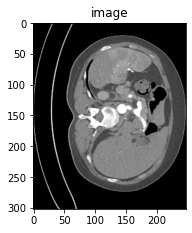

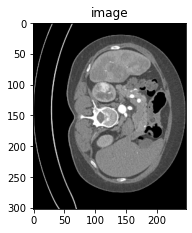

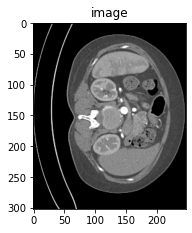

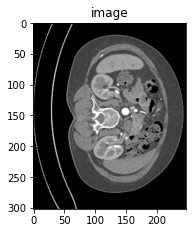

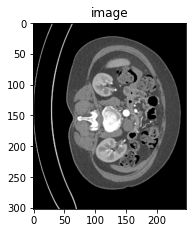

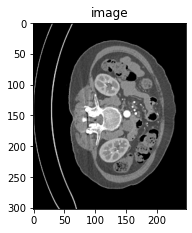

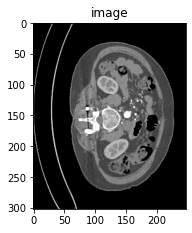

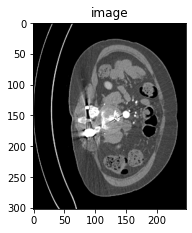

torch.Size([1, 1, 302, 231, 38])


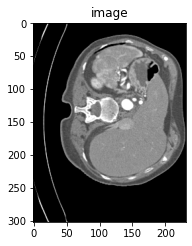

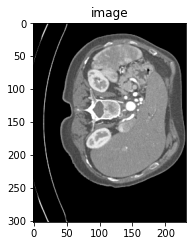

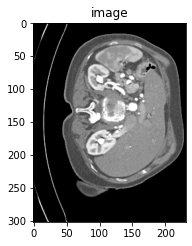

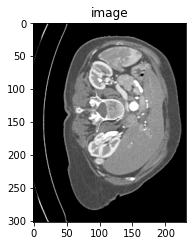

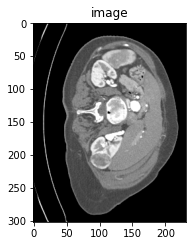

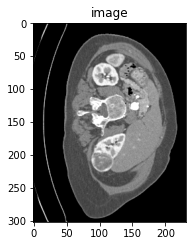

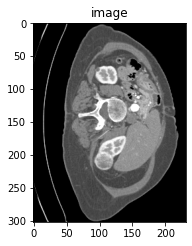

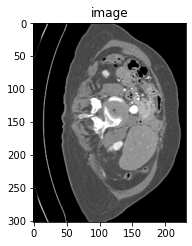

torch.Size([1, 1, 299, 225, 38])


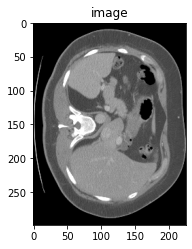

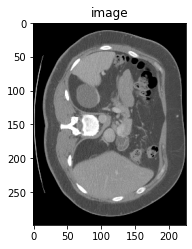

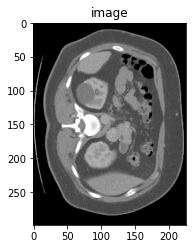

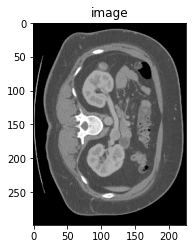

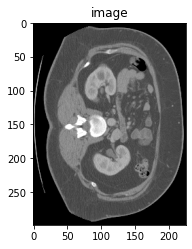

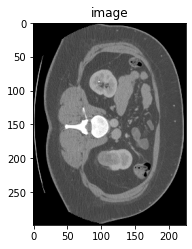

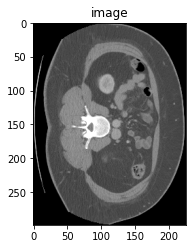

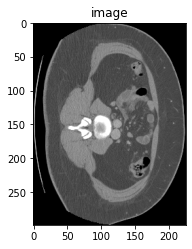

In [ ]:
j=0
for test_image in test_loader:
  print(test_image['image'].shape)
  for i in range(8):
    image=test_image['image'][0]
    plt.figure("check", (6,6))
    plt.subplot(1,2,1)
    plt.title(f"image {i}")
    plt.imshow(image[0, :, :, i*5+1].detach().cpu(), cmap="gray")
    plt.show()
  j+=1
  if j==3:
    break

In [ ]:
device = torch.device("cuda:0")
!nvidia-smi

Thu Sep  2 18:44:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:01:00.0 Off |                  N/A |
| 37%   33C    P8    22W / 350W |   6497MiB / 24265MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# pip install einops

In [ ]:
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

in_channels=1,
    out_channels=3, #classes
    img_size=(96, 96, 32),
    feature_size=8, #16
    hidden_size=384, #768
    mlp_dim=1536, #3072
    num_heads=12,
    pos_embed="perceptron", #perceptron
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
    lr=1e-4, weight_decay=1e-5
    max_iterations = 50
    eval_num = 5
    train completed, best_metric: 0.0086 at iteration: 5
    //
        in_channels=1,
    out_channels=3, #classes
    img_size=(96, 96, 32),
    feature_size=8, #16
    hidden_size=384, #768
    mlp_dim=1536, #3072
    num_heads=12,
    pos_embed="perceptron", #perceptron
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
    lr=1e-5, weight_decay=1e-5
    max_iterations = 200
eval_num = 10
train completed, best_metric: 0.3352 at iteration: 200

In [ ]:
out_dir='/Volumes/moai2021/result/naejung/20210831'
import nibabel as nib

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "0831_best_metric_model_v1.pth"))) # change!!!!!!!!!!!
model.eval()

final_outputs = []

with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(
            test_data["image"].to(device), roi_size, sw_batch_size, model
        )
        img = test_data["image"]
        test_inputs = torch.unsqueeze(img, 1).to(device)
        test_outputs_new=np.array(torch.argmax(test_outputs, dim=1).detach().cpu().numpy()[0],dtype=np.float64)
        final_outputs.append(test_outputs_new)
        ##print('#####')
        ##print(val_outputs_new)
        #print(val_data['image_meta_dict']['affine'][0][0])
        #h1=nib.Nifti1Image(val_inputs.cpu().numpy()[0],val_data['image_meta_dict']['affine'][0])
        #nib.save(h1,os.path.join(out_dir,f'val_{case_num}_image.nii.gz'))
        #h2=nib.Nifti1Image(val_outputs_new,val_data['image_meta_dict']['affine'][0])
        #nib.save(h2,os.path.join(out_dir,f'val_{case_num}_pred.nii.gz'))
        # plot the slice [:, :, 80]
        sl=15
        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"image {i}")
        plt.imshow(test_data["image"][0, 0, :, :, sl], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            test_outputs, dim=1).detach().cpu()[0, :, :, sl])
        plt.show()
        #if i==3:
        #    break

NameError: name 'model' is not defined

In [ ]:
print(test_outputs) # 5D?
print(test_outputs_new.shape) # 3D?
print(final_outputs.shape)

In [ ]:
for i, tmp1 in enumerate(final_outputs):
    tmp1=torch.Tensor(tmp1)
    tmp1=tmp1.unsqueeze(0)
    tmp1=tmp1.unsqueeze(0)
    tmp1.shape
#print(val_outputs_new)

In [ ]:
from monai.transforms.utils import generate_spatial_bounding_box

tmp1=val_outputs_new[0].numpy()
a1,b1=generate_spatial_bounding_box(tmp1[:,:150]) #check
a2,b2=generate_spatial_bounding_box(tmp1[:,150:])

In [ ]:
print(a1,b1,a2,b2)  

In [ ]:
#tmp1=val_outputs_new 
tmp1[:,a1[0]:b1[0],a1[1]:b1[1],a1[2]:b1[2]]=1
tmp1[:,(150+a2[0]):(150+b2[0]),a2[1]:b2[1],a2[2]:b2[2]]=1
#tmp1[a1[0]:b1[0],a1[1]:b1[1]]=1
#tmp1[(150+a2[0]):(150+b2[0]),a2[1]:b2[1]]=1
temp=val_data["image"][0]*tmp1

In [ ]:
val_data['image'].shape

In [ ]:
img = temp
label = tmp1

img_shape = img.shape
label_shape = label.shape

print(f"image shape: {img_shape}, label shape: {label_shape}")
l=1
plt.subplot(1,2,1)
plt.title(f"image {i}")
plt.imshow(temp[0,:, :, l], cmap="gray")
plt.subplot(1,2,2)
plt.title(f"label {i}")
plt.imshow(tmp1[0,:, :, l])

STEP 2

In [ ]:
class ConvertToMultiChannel(MapTransform):
    """
    Convert labels to multi channels:
    """
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(d[key].astype(np.int8) >0)
#            result.append(d[key].astype(np.int8) == 1)
#            result.append(d[key].astype(np.int8) == 2)
#            result.append(d[key].astype(np.int8) == 4)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d



def masked(data_dict):
    a1,b1=generate_spatial_bounding_box(data_dict['label'][:,:200]) #check
    a2,b2=generate_spatial_bounding_box(data_dict['label'][:,200:])
    tmp1= data_dict['label'][0]
    tmp1[a1[0]:b1[0],a1[1]:b1[1],a1[2]:b1[2]]=1
    tmp1[(200+a2[0]):(200+b2[0]),a2[1]:b2[1],a2[2]:b2[2]]=1
    data_dict["image"]=data_dict["image"]*tmp1
    return data_dict


train_transforms_step2 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image"]),
        ConvertToMultiChannel(keys=["label"]), 
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.3, 1.3, 1.3), #check
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image"], axcodes="RAS"),
        Orientationd(keys=["label"], axcodes="RPS"),
        masked,
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-285,
            a_max=350,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
       
       # removed random agmentation
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms_step2 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image"]),
        ConvertToMultiChannel(keys=["label"]), 
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.3, 1.3, 1.3), #check
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image"], axcodes="RAS"),
        Orientationd(keys=["label"], axcodes="RPS"),
        masked,
        ScaleIntensityRanged(
            keys=["image"], a_min=-285, a_max=350, b_min=0.0, b_max=1.0, clip=True
        ),
       
        ToTensord(keys=["image", "label"]),
    ]
)


In [ ]:
train_ds_2 = CacheDataset(
    data=train_f,
    transform=train_transforms_step2,
    cache_num=1, 
    # It is recommended to experiment with different cache_num or cache_rate to identify the best training speed.
    cache_rate=1.0,
    num_workers=0,
)
train_loader_2 = DataLoader(
    train_ds_2, batch_size=2, shuffle=True, num_workers=0, pin_memory=True
)

val_ds_2 = CacheDataset(
    data=val_f, transform=val_transforms_step2, cache_num=1, cache_rate=1.0, num_workers=0
)
val_loader_2 = DataLoader(
    val_ds_2, batch_size=1, shuffle=False, num_workers=0, pin_memory=True
)

In [ ]:
#a1,b1=generate_spatial_bounding_box(train_ds_2[0]['label'][:,:200].numpy()) #check
#a2,b2=generate_spatial_bounding_box(train_ds_2[0]['label'][:,200:].numpy())


In [ ]:
case_num = 0
#img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = train_ds_2[case_num]["image"]
label = train_ds_2[case_num]["label"]
#label[0,a1[0]:b1[0],a1[1]:b1[1],a1[2]:b1[2]]=1
img_shape = img.shape
label_shape = label.shape

print(f"image shape: {img_shape}, label shape: {label_shape}")
for i in range(0,4):
  plt.figure("image", (18, 6))
  plt.subplot(1, 2, 1)
  plt.title("image")
  plt.imshow(img[0, :, :, i*5+1].detach().cpu(), cmap="gray")
  plt.subplot(1, 2, 2)
  plt.title("label")
  plt.imshow(label[0, :, :, i*5+1].detach().cpu())
  plt.show()